# COVID-19 Model 

It's assumed the people are indicated to do a quarantine, reducing their contact to $100r$ of their usual contacts.

Consider some parameters: 

| Parameter | Explanation |
|-----| ----------------------------------------|
| $p$ | fraction of population in $r$-isolation |
| $\tau$ | inverse of the latent time |
| $\sigma$ | inverse of time before clear symptoms such to ensure isolation or testing of the subject |
| $\theta$ | $\tau + \sigma$ inverse of mean incubation time | 
| $\alpha$ | asymptomatic rate |
| $\delta$ | probability of positive test in compartment $E$ |
| $\gamma_1$ | recovery rate for asymptomatic or mild symptoms|
| $\gamma_2$ | recovery rate for $Q$ |
| $\mu$ | mortality rate of infected symptomatic |
| $\beta(t)$ |contact rate among people free to move |
| $\rho(t)$ | proportion of tests done in no infected with severe symptoms |
| $r(t)$ | reduction coefficient of contact rate |

## SEIR with Q model

Consider the state $X = (E_f, E_r, I_f, I_r, A_f, A_r, Q, S_f, S_r, R, D)$, where

| State | Explanation |
| ----- | ---------------------------------------------------- |
| $E_f$ | exposed, not in isolation, not contagious |
| $E_r$ | exposed, in volunteer $r$-isolation, not contagious |
| $I_f$ | asymptomatic infected, not in isolation | 
| $I_r$ | asymptpmatic infected, in volunteer $r$-isolation |
| $A_f$ | Asymptomatic and contagious, not in isolation |
| $A_r$ | Asymptomatic and contagious, r-isolation |
| $Q$ | infected and tested positive, in enforced quarantine | 
| $S_f$ | susceptible not in isolation |
| $S_q$ | susceptible in volunteer $r$-isolation |
| $R$ | recovered and immune |
| $D$ | deaths |

The dynamics is described as follows:

$$
    \begin{array}{l}
    \dot{E}_f = \beta(t) S_f [I_f + A_f + r(t)(I_r + A_r) + \epsilon Q] - \rho(t)\delta E_f - \tau E_f \\[0.5ex]
    \dot{E}_r = r(t) \beta(t) S_r [I_f + A_f + r(t)(I_r + A_r) + \epsilon Q] - \rho(t)\delta E_r - \tau E_r \\[0.5ex]
    \dot{I}_f = \tau E_f - \sigma I_f - \rho(t)I_f \\[0.5ex]
    \dot{I}_r = \tau E_r - \sigma I_r - \rho(t)I_r  \\[0.5ex]
    \dot{A}_f = \sigma\alpha I_f - \rho(t)A_f - \gamma_1 A_f \\[0.5ex]
    \dot{A}_r = \sigma\alpha I_r - \rho(t)A_r - \gamma_1 A_r \\[0.5ex]
    \dot{Q} = \sigma (1-\alpha) [I_f + I_r] + \rho(t)(\delta(E_f + E_r) + I_f + I_r + A_f + A_r) - \gamma_2 Q - \mu Q \\[0.5ex]
    \dot{S}_f = -\beta(t)S_f [I_f + A_f + r(t)(I_r + A_r) + \epsilon Q] \\[0.5ex]
    \dot{S}_r = -r(t)\beta(t)S_r [I_f + A_f + r(t)(I_r + A_r) + \epsilon Q] \\[0.5ex]
    \dot{R} = \gamma_1 (A_f + A_r) + \gamma_2 Q \\[0.5ex]
    \dot{D} = \mu Q
    \end{array}
$$

#### Importing modules

In [1]:
import sympy as sp
import numpy as np
sp.init_printing(use_unicode = True)

from paths import *
from pyscripts.dynamics_model import Dynamics
from pyscripts.calc_r0 import calc_R0

## Calculating $R_0$

#### Using symbolic programming

In [2]:
t, tau, sigma, alpha, delta, epsilon, gamma1, gamma2, mu, p = sp.symbols('t tau sigma alpha delta epsilon gamma1 gamma2 mu p')
beta, r, rho = sp.Function("beta"), sp.Function("r"), sp.Function("rho")
#beta, r, rho = sp.symbols('beta r rho')
Ef, Er, If, Ir, Af, Ar, Q, Sf, Sr, R, D, T = sp.symbols('Ef Er If Ir Af Ar Q Sf Sr R D T')

#### Calculating $B_{\lambda}$ 

In [3]:
X = [Ef, Er, If, Ir, Af, Ar, Q, Sf, Sr, R, D, T]
Diff = Dynamics(beta, r, tau, sigma, alpha, rho, delta, epsilon, gamma1, gamma2, mu)

fX = [Diff.diffEf(t,X), Diff.diffEr(t,X), Diff.diffIf(t,X), Diff.diffIr(t,X), Diff.diffAf(t,X), Diff.diffAr(t,X),
      Diff.diffQ(t,X), Diff.diffSf(t,X), Diff.diffSr(t,X)]

determine_R0 = calc_R0(X[:-3], [Ef, Er, If, Ir, Af, Ar, Q], fX)

In [4]:
eigen = sp.symbols("lambda")
Blambda = determine_R0.Jacobian[0:7, 0:7] - eigen*sp.eye(7)
Blambda = Blambda.subs({Sf: 1- p, Sr: p})
Blambda = sp.Matrix(Blambda)

We can see that $\lambda_1 = -\rho(t) - \gamma_1$, because $det(B_{\lambda}) = \alpha^2 \sigma^2 \tau^2 \cdot det(b)$, where $b = [b14, b15, b16; b24, b25, b26; b64, b65, b66]$ has determinant 0. Also, because of first and second lines are proportional, $\lambda_2 = -\tau - \delta\cdot\rho(t)$. We found, also that $\lambda_3 = - \sigma - \rho(t) $

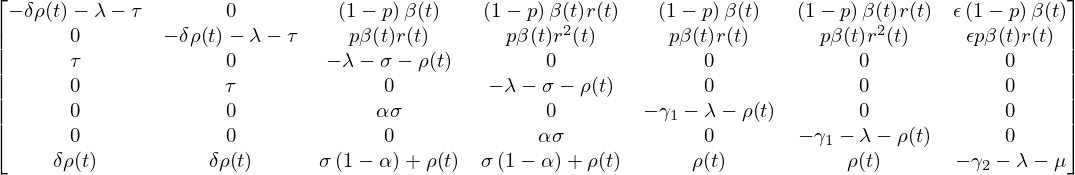

In [5]:
Blambda

Calculating the determinant of this matrix (Characteristic polynomial), factorization and simplification with the eigenvalues already found. 

In [5]:
det = sp.det(Blambda)

In [6]:
factoring = sp.factor(det)
simp = factoring/((gamma1 + eigen + rho(t))*(eigen + sigma + rho(t))*(delta*rho(t) + eigen + tau))

Now, let's consider $\epsilon = 0$, to simplify. So, $\lambda = - \gamma_2 - \mu$ will be a root, so, an eigenvalue. This is the resulting polynomial

$${\left(\alpha \beta p r^{2} \sigma \tau + \beta \lambda p r^{2} \tau + \beta \gamma_{1} p r^{2} \tau + \beta p r^{2} \rho \tau - \alpha \beta p \sigma \tau - \delta \lambda^{2} \rho - \delta \lambda \gamma_{1} \rho - 2 \, \delta \lambda \rho^{2} - \delta \gamma_{1} \rho^{2} - \delta \rho^{3} - \delta \lambda \rho \sigma - \delta \gamma_{1} \rho \sigma - \delta \rho^{2} \sigma - \beta \lambda p \tau - \beta \gamma_{1} p \tau - \beta p \rho \tau + \alpha \beta \sigma \tau - \lambda^{3} - \lambda^{2} \gamma_{1} - 2 \, \lambda^{2} \rho - \lambda \gamma_{1} \rho - \lambda \rho^{2} - \lambda^{2} \sigma - \lambda \gamma_{1} \sigma - \lambda \rho \sigma + \beta \lambda \tau - \lambda^{2} \tau + \beta \gamma_{1} \tau - \lambda \gamma_{1} \tau + \beta \rho \tau - 2 \, \lambda \rho \tau - \gamma_{1} \rho \tau - \rho^{2} \tau - \lambda \sigma \tau - \gamma_{1} \sigma \tau - \rho \sigma \tau\right)}$$

$$\alpha \beta p r^{2} \sigma \tau + \beta \gamma_{1} p r^{2} \tau + \beta p r^{2} \rho \tau - \alpha \beta p \sigma \tau - \delta \gamma_{1} \rho^{2} - \delta \rho^{3} - \delta \gamma_{1} \rho \sigma - \delta \rho^{2} \sigma - \beta \gamma_{1} p \tau - \beta p \rho \tau + \alpha \beta \sigma \tau - {\left(\delta \rho + \gamma_{1} + 2 \, \rho + \sigma + \tau\right)} \lambda^{2} - \lambda^{3} + \beta \gamma_{1} \tau + \beta \rho \tau - \gamma_{1} \rho \tau - \rho^{2} \tau - \gamma_{1} \sigma \tau - \rho \sigma \tau + {\left(\beta p r^{2} \tau - \delta \gamma_{1} \rho - 2 \, \delta \rho^{2} - \delta \rho \sigma - \beta p \tau - \gamma_{1} \rho - \rho^{2} - \gamma_{1} \sigma - \rho \sigma + \beta \tau - \gamma_{1} \tau - 2 \, \rho \tau - \sigma \tau\right)} \lambda
$$


In [44]:
lambd = sp.symbols("lambda")
P1 = lambda lamb: rho(t)*delta*r(t)*epsilon*beta(t)*p + rho(t)*delta*epsilon*beta(t)*(1 - p) - (rho(t)*delta + tau + lamb)*(gamma2 + mu + lamb)
P2 = lambda lamb: beta(t)*(rho(t) + gamma1 + lamb)*(gamma2 + mu + lamb)*(1 - p + (r(t)**2)*p) + sigma*alpha*rho(t)*epsilon*beta(t)*(1 - p + r(t)*p) + (rho(t) + gamma1 + lamb)*(sigma*(1 - alpha) + rho(t))*epsilon*beta(t)*(1 - p + r(t)*p) + (gamma2 + mu + lamb)*sigma*alpha*beta(t)*(1 - p + (r(t)**2)*p)
detBlambda_f = ((sigma + rho(t) + lambd)*(rho(t) + gamma1 + lambd)*P1(lambd) + tau*P2(lambd))

### Thanks